Dati inerenti al volume d'acqua erogato.
Quello che vorrei fare è prendere tutti i dati e creare una tabella con due colonne, una timestamp e l'altra con i valori

In [812]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from river import facto
from river import compat
from river import tree

In [619]:
path = r'C:\Users\giode\PycharmProjects\Script_Tesi_new\Dati\Urban Water Demand Data.txt'

def load_idraulic_press_data(data_path):

       dati = pd.read_csv(path, sep='\t', index_col=False, header=0, names=('date','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))


       date = dati.date
       dati = dati.drop("date", axis= 1)

       dati = dati.stack().reset_index()

       list_date = []
       for i in date:
              for a in range(0,24):
                     list_date.append(i)

       list_hour = []
       i = 0
       for a in range(0,dati.shape[0]):
              list_hour.append(i)
              i +=1
              if(i == 24):
                     i=0


       dati['date'] = list_date

       dati = dati.rename(columns = {'level_0':'Count_days','level_1':'Hours',0:'Water_volume'})
       dati = dati[['Count_days','date','Hours','Water_volume']]


       dati['date'] = pd.to_datetime(dati['date'], format='%d-%m-%Y')


       dati['days'] = dati['date'].dt.day

       dati['month'] =  dati['date'].dt.month

       dati['hour'] =  list_hour

       return dati

In [620]:
dati = load_idraulic_press_data(path)
dati.to_csv('dativolum.csv')

C:\Users\giode\AppData\Local\Temp\ipykernel_19332\3271519208.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dati = pd.read_csv(path, sep='\t', index_col=False, header=0, names=('date','00:00-00:59','01:00-01:59','02:00-02:59','03:00-03:59','04:00-04:59','05:00-05:59','06:00-06:59','07:00-07:59','08:00-08:59','09:00-09:59','10:00-10:59','11:00-11:59','12:00-12:59','13:00-13:59','14:00-14:59','15:00-15:59','16:00-16:59','17:00-17:59','18:00-18:59','19:00-19:59','20:00-20:59','21:00-21:59','22:00-22:59','23:00-23:59'))


In [741]:
dati.head()

,Count_days,date,Hours,Water_volume,days,month,hour
0,0,2012-10-02,00:00-00:59,13815.2,2,10,0
1,0,2012-10-02,01:00-01:59,13290.0,2,10,1
2,0,2012-10-02,02:00-02:59,13416.2,2,10,2
3,0,2012-10-02,03:00-03:59,13424.6,2,10,3
4,0,2012-10-02,04:00-04:59,14607.3,2,10,4


In [13]:
dati.Water_volume.isna().sum()

0

In [727]:
dati.shape[0]

8496

<AxesSubplot:>

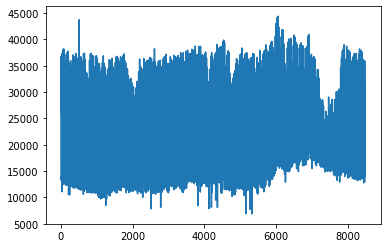

In [14]:
dati.Water_volume.plot()

In [622]:
path = r'C:\Users\giode\PycharmProjects\Script_Tesi_new\Script\DatiTesi\dativolum.csv'

In [623]:
dati.columns

Index(['Count_days', 'date', 'Hours', 'Water_volume', 'days', 'month', 'hour'], dtype='object')

In [722]:
def initial_iter():

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'Water_volume': float,
                     'days': int,
                     'month': int,
                     'hour': int,
                     '': int
                     },
              parse_dates={'date': '%Y-%m-%d'},
              target='Water_volume'
                      )
       return X_y

In [641]:
X_y = initial_iter()


In [668]:
x, y = next(X_y)
x, y

({'': 26,
  'Count_days': 1,
  'date': datetime.datetime(2012, 10, 3, 0, 0),
  'Hours': '02:00-02:59',
  'days': 3,
  'month': 10,
  'hour': 2},
 11279.2)

In [681]:
X_y = initial_iter()
model = compose.Select( 'Count_days', 'hour')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.1))

metric = metrics.MAE()

evaluate.progressive_val_score(X_y, model, metric, print_every=1000)


[1,000] MAE: 4,298.506589
[2,000] MAE: 3,929.833892
[3,000] MAE: 3,824.85212
[4,000] MAE: 3,794.785101
[5,000] MAE: 3,789.000472
[6,000] MAE: 3,777.117148
[7,000] MAE: 3,694.531585
[8,000] MAE: 3,522.518448


MAE: 3,518.359897

In [479]:
def get_hour(x):

    x['hour'] = x['date'].hour
    return x

In [682]:
X_y = initial_iter()
model = compose.Select( 'Count_days', 'hour')

model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(days=1),
       print_every=1000
)

[1,000] MAE: 7,318.22845
[2,000] MAE: 6,792.655681
[3,000] MAE: 6,604.58596
[4,000] MAE: 6,569.511179
[5,000] MAE: 6,511.104836
[6,000] MAE: 6,480.335698
[7,000] MAE: 6,364.580589
[8,000] MAE: 6,085.206851


MAE: 6,073.956837

In [683]:
X_y = initial_iter()

model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

In [718]:
X_y = initial_iter()


In [729]:
for i in range(0,8496):
       x, y = next(X_y)
       print(x)

{'': 35, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '11:00-11:59', 'days': 3, 'month': 10, 'hour': 11}
{'': 36, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '12:00-12:59', 'days': 3, 'month': 10, 'hour': 12}
{'': 37, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '13:00-13:59', 'days': 3, 'month': 10, 'hour': 13}
{'': 38, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '14:00-14:59', 'days': 3, 'month': 10, 'hour': 14}
{'': 39, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '15:00-15:59', 'days': 3, 'month': 10, 'hour': 15}
{'': 40, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '16:00-16:59', 'days': 3, 'month': 10, 'hour': 16}
{'': 41, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hours': '17:00-17:59', 'days': 3, 'month': 10, 'hour': 17}
{'': 42, 'Count_days': 1, 'date': datetime.datetime(2012, 10, 3, 0, 0), 'Hou

StopIteration: 

In [ ]:
evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(days=1),
       print_every=1000
)


Text(0.5, 1.0, 'MAE: 5,609.964017\t(rolling 7)')

C:\Users\giode\PycharmProjects\Script_Tesi_new\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


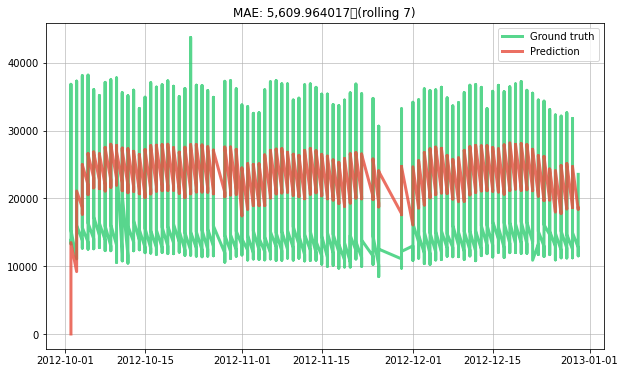

In [763]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 7)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( '', 'hour', 'days', 'Count_days')
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))



for i in range(0,2000):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(x['date'])
       y_trues.append(y)
       y_preds.append(y_pred)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

Text(0.5, 1.0, 'MAE: 2,462.724411\t(rolling 7)')

C:\Users\giode\PycharmProjects\Script_Tesi_new\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


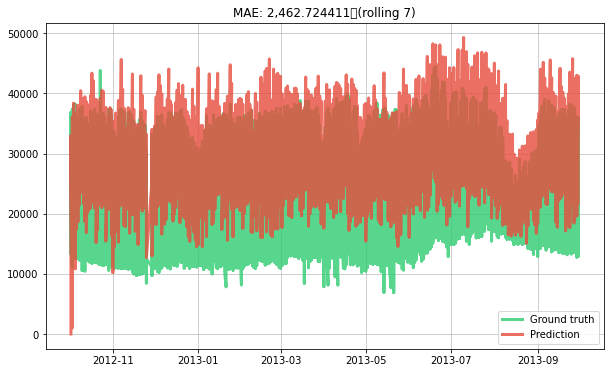

In [764]:
from river import metrics
import matplotlib.pyplot as plt

metric = metrics.Rolling(metrics.MAE(), 7)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( '', 'hour', 'days', 'Count_days')
model |= preprocessing.StandardScaler()
model |= linear_model.PARegressor(
       C=0.01,
       mode=2,
       eps=0.1,
       learn_intercept=False
)



for i in range(0,8496):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(x['date'])
       y_trues.append(y)
       y_preds.append(y_pred)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

Text(0.5, 1.0, 'MAE: 1,944.409749\t(rolling 7)')

C:\Users\giode\PycharmProjects\Script_Tesi_new\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


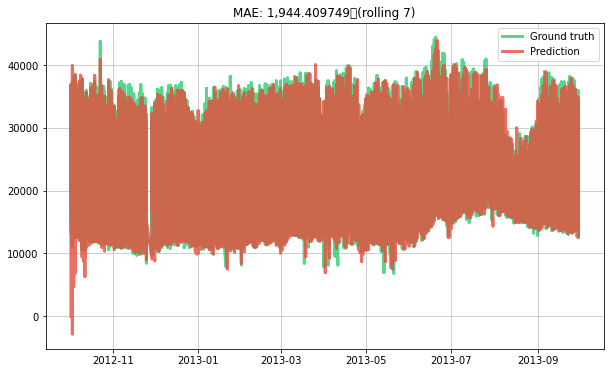

In [789]:
from river import metrics
import matplotlib.pyplot as plt


metric = metrics.Rolling(metrics.MAE(), 7)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( '', 'hour', 'days', 'Count_days')
model |= preprocessing.StandardScaler()

model |= ensemble.AdaptiveRandomForestRegressor()
for i in range(0,8496):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(x['date'])
       y_trues.append(y)
       y_preds.append(y_pred)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

In [786]:
X_y = initial_iter()
model = compose.Select( '', 'hour', 'days', 'Count_days')

model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor()

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(days=7),
       print_every=1000
)

[1,000] MAE: 30,117.880018
[2,000] MAE: 17,755.923125
[3,000] MAE: 13,005.290552
[4,000] MAE: 10,299.425698
[5,000] MAE: 8,723.123964
[6,000] MAE: 7,612.78988
[7,000] MAE: 6,898.000676
[8,000] MAE: 6,595.118928


MAE: 6,395.702299

Text(0.5, 1.0, 'MAE: 5,043.276853\t(rolling 7)')

C:\Users\giode\PycharmProjects\Script_Tesi_new\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


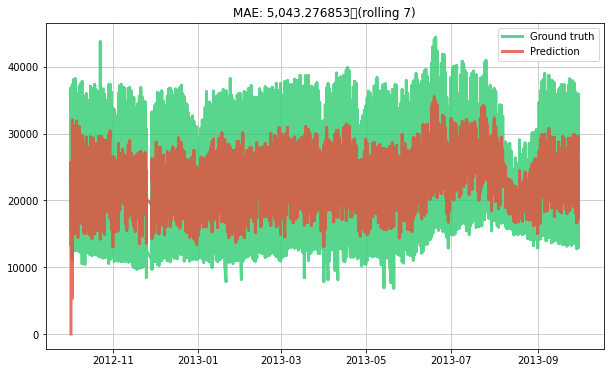

In [790]:
from river import metrics
import matplotlib.pyplot as plt


metric = metrics.Rolling(metrics.MAE(), 7)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

model = compose.Select( '', 'hour', 'days', 'Count_days')
model |= preprocessing.StandardScaler()

model |= ensemble.BaggingRegressor(
       model=linear_model.LinearRegression(),
       n_models=3
)
for i in range(0,8496):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(x['date'])
       y_trues.append(y)
       y_preds.append(y_pred)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)

In [791]:
X_y = initial_iter()
model = compose.Select( '', 'hour', 'days', 'Count_days')

model |= preprocessing.StandardScaler()
model |= ensemble.BaggingRegressor(
       model=linear_model.LinearRegression(),
       n_models=3
)

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       moment='date',
       delay=dt.timedelta(days=7),
       print_every=1000
)

[1,000] MAE: 25,202.845477
[2,000] MAE: 16,271.307156
[3,000] MAE: 13,262.749942
[4,000] MAE: 11,771.51065
[5,000] MAE: 10,804.097182
[6,000] MAE: 10,230.971646
[7,000] MAE: 9,671.292321
[8,000] MAE: 9,105.594584


MAE: 8,945.79974

Text(0.5, 1.0, 'MAE: 66,431,526,073,385,424.\t(rolling 7)')

C:\Users\giode\PycharmProjects\Script_Tesi_new\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


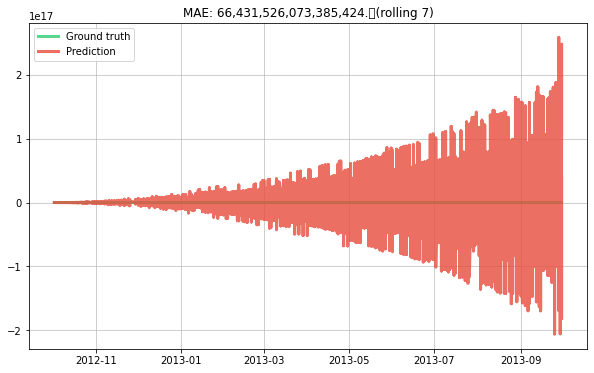

In [815]:
from river import metrics
import matplotlib.pyplot as plt


metric = metrics.Rolling(metrics.MAE(), 7)

dates = []
y_trues = []
y_preds = []

X_y = initial_iter()

base_model = tree.HoeffdingTreeRegressor(grace_period=50)
model = compose.Select( '', 'hour', 'days', 'Count_days')
model |= ensemble.SRPRegressor(
       model=base_model,
       training_method='patches',
       n_models=10
)
for i in range(0,8496):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric.update(y, y_pred)

       # Store the true value and the prediction
       dates.append(x['date'])
       y_trues.append(y)
       y_preds.append(y_pred)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()
ax.set_title(metric)